## Compare UI Ekman and UI SST

#### Main things covered here:
- Overview plots, time period and region
- Trend analysis
- Stats: trend significance and correlation

#### Other Info 
- Plot the datasets against each other (a positive Ek UI (seaward) should roughly correlate to negative SST UI (mid shelf Ts lower than at reference point 15°W)
- I compare the UI Ek at 10°W with the UI SST (calculated: 15°w - mid shelf)

In [1]:
## import packages
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import matplotlib.patches as mpatches
import matplotlib
import cartopy.crs as ccrs
import glob
import os
import my_functions
import datetime
import statsmodels.api as sm
%matplotlib inline

In [2]:
## import data
os.chdir('/Users/marie-louisekorte/Documents/Uni Leipzig/Lisbon/Data.nosync/')
MTSS = xr.open_dataset('MTSS_weekly.nc')
UI_SST = UI_SST = xr.open_dataset('UI_SST.nc')
LSM = xr.open_dataset('Land_sea_mask.nc')
SSH = xr.open_dataset('SSH_weekly.nc') # SSH IBI
# mid-shelf coordinates
mid_shelf_lat = np.genfromtxt('CoRTAD/lat_midshelf_CoRTAD.dat')[:,1]
mid_shelf_lon = np.genfromtxt('CoRTAD/lon_midshelf_CoRTAD.dat')[:,1]

In [3]:
## preprocessing steps
# add the land sea mask to the MTSS dataset
MTSS['lsm'] = LSM.lsm

# calculate upwelling index from wind stress dataset -> use my upwelling function (from my_functions.py)
UI_Ek = my_functions.calc_upwelling_index(MTSS, MTSS.lat, MTSS.lon, MTSS.metss, MTSS.mntss)
# SSH upwelling index
# first mid-shelf
SSH = my_functions.add_mid_shelf(SSH, mid_shelf_lat, mid_shelf_lon)
SSH['UI'] = SSH.zos.where(SSH.lon == -10.5) - SSH.zos.where(SSH.mid_shelf).mean(dim = 'lon')
SSH.UI.attrs.update({'Name' : 'SSH upwelling index', 'Info' : 'SSH at 10.5°W - SSH at mid-shelf'})

# calculate meridional mean (1D Portuguese upwelling index), does meridional mean of UI by default
UI_Ek = my_functions.calc_meridional_mean(UI_Ek, lon = -10.5) # change to lon -10.5 to match SSH slected location (made this decision together wiht Joaquim, just seemed a good enough distance away from land)
UI_SST = my_functions.calc_meridional_mean(UI_SST, lon = -15) # specifying lon does not really matter as it is equal across al lons
UI_SSH = my_functions.calc_meridional_mean(SSH, lon = -10.5)

# create subset of summer months, June-September (week 22-39), subsets week 22-39 by default (adds weeks and months)
UI_Ek_summer = my_functions.subset_summer(UI_Ek)
UI_SST_summer = my_functions.subset_summer(UI_SST)
UI_SSH_summer = my_functions.subset_summer(UI_SSH)

# add mid_shelf
UI_Ek = my_functions.add_mid_shelf(UI_Ek, mid_shelf_lat, mid_shelf_lon)

## Plot Time Series (single point and mean)

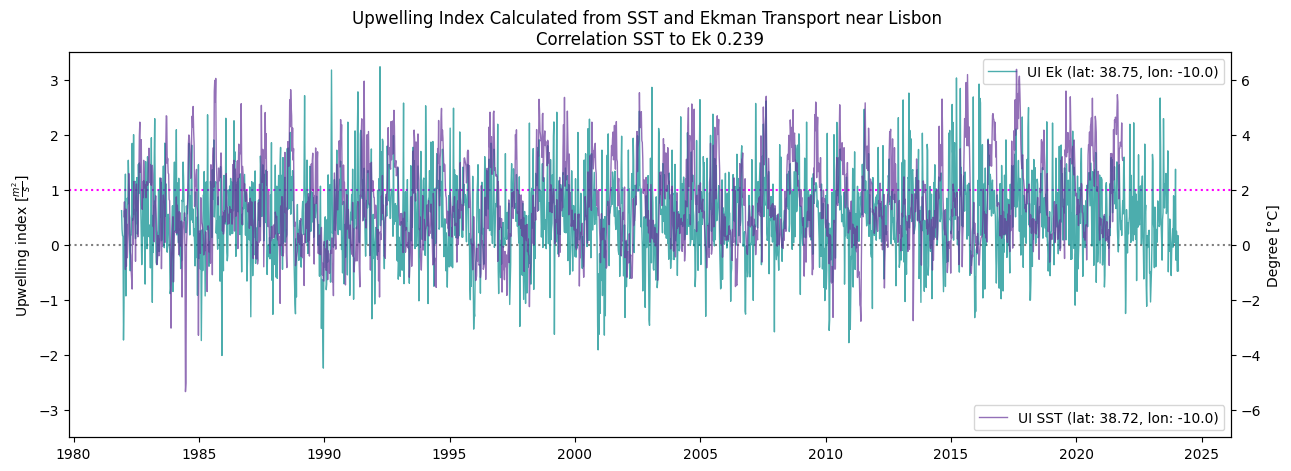

In [4]:
## compare UIs at one point near Lisbon
fig, ax1 = plt.subplots(figsize=(15,5))

# 0 line
plt.axhline(0, color = 'k', linestyle = ':', alpha = 0.5);
# -2°C line (as signifier for an upwelling event, -2/3 on primary axis = -2 on secondary)
plt.axhline(1, color = 'magenta', linestyle = ':')

# primary axis
ax1.plot(UI_Ek.time, UI_Ek.UI.sel(lat = 38.7, lon = -10, method = 'nearest'), 
         label = f"UI Ek (lat: {UI_Ek.lat.sel(lat = 38.7, method = 'nearest').values.round(2)}, lon: {UI_Ek.lon.sel(lon = -10, method = 'nearest').values.round(2)})",
         color = 'darkcyan', alpha = 0.7, linewidth = 1)
# secondary axis 
ax2 = ax1.twinx()
ax2.plot(UI_SST.time, UI_SST.UI.sel(lat = 38.7, lon = -10, method = 'nearest'), 
         label = f"UI SST (lat: {UI_SST.lat.sel(lat = 38.7, method = 'nearest').values.round(2)}, lon: {UI_SST.lon.sel(lon = -10, method = 'nearest').values.round(2)})",
         color = 'rebeccapurple', alpha = 0.7, linewidth = 1)

# layout 
ax1.set_ylabel(r'Upwelling index [$\frac{m^{2}}{s}$]');
ax1.set_ylim(-3.5, 3.5)
ax1.legend(loc = 0)

ax2.set_ylabel('Degree [°C]')
ax2.set_ylim(-7,7)
ax2.legend(loc = 4)

# correlation 
# my UI_Ek starts a little earlier and is a little longer adjust time to match
corr = np.corrcoef(UI_SST.UI.sel(lat = 38.7, lon = -10, method = 'nearest').values, 
                   UI_Ek.UI.sel(lat = 38.7, lon = -10, method = 'nearest').isel(time = slice(5, 2085)).values) 

plt.title(f'Upwelling Index Calculated from SST and Ekman Transport near Lisbon \nCorrelation SST to Ek {corr[0,1]:.3f}')
plt.xlabel('Time [yr]');

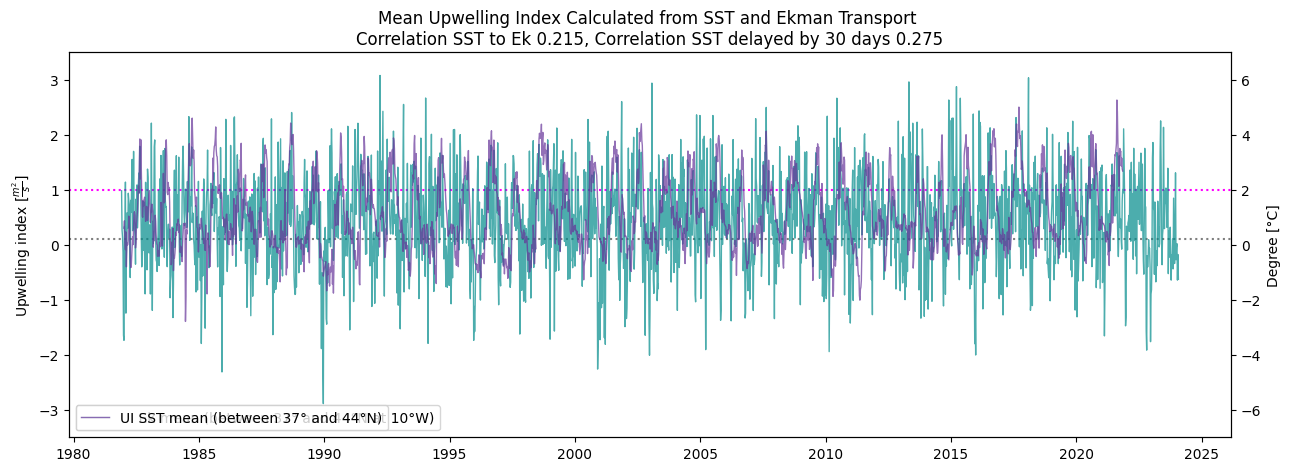

In [5]:
## compare UI means
fig, ax1 = plt.subplots(figsize=(15,5))

# 0 line
plt.axhline(0.1, color = 'k', linestyle = ':', alpha = 0.5);
# -2°C line (as signifier for an upwelling event, -2/3 on primary axis = -2 on secondary)
plt.axhline(1, color = 'magenta', linestyle = ':')

# primary axis
ax1.plot(UI_Ek.time, UI_Ek.UI_mean,
         label = f"UI Ek mean (between 37° and 44°N at 10°W)", color = 'darkcyan', 
         alpha = 0.7, linewidth = 1)
# secondary axis 
ax2 = ax1.twinx()
ax2.plot(UI_SST.time, UI_SST.UI_mean, 
         label = f"UI SST mean (between 37° and 44°N)",
         color = 'rebeccapurple', alpha = 0.7, linewidth = 1)


# layout 
ax1.set_ylabel(r'Upwelling index [$\frac{m^{2}}{s}$]');
ax1.set_ylim(-3.5, 3.5)
ax1.legend(loc = 0)

ax2.set_ylabel('Degree [°C]')
ax2.set_ylim(-7,7)
ax2.legend(loc = 3)

# correlation 
# my UI_Ek starts a little earlier and is a little longer adjust time to match
corr = np.corrcoef(UI_SST.UI_mean.values, UI_Ek.UI_mean.isel(time = slice(5, 2085)).values) 
corr_30_delay = np.corrcoef(UI_SST.UI_mean.values, UI_Ek.UI_mean.isel(time = slice(1, 2081)).values) 

plt.title(f'Mean Upwelling Index Calculated from SST and Ekman Transport \nCorrelation SST to Ek {corr[0,1]:.3f}, Correlation SST delayed by 30 days {corr_30_delay[0,1]:.3f}')
plt.xlabel('Time [yr]');

# plt.savefig('../Iberian_Coast_Upwelling/Figures/Overview_UI_Mean.png', dpi = 300)

Text(0.5, 0, 'Time [yr-m]')

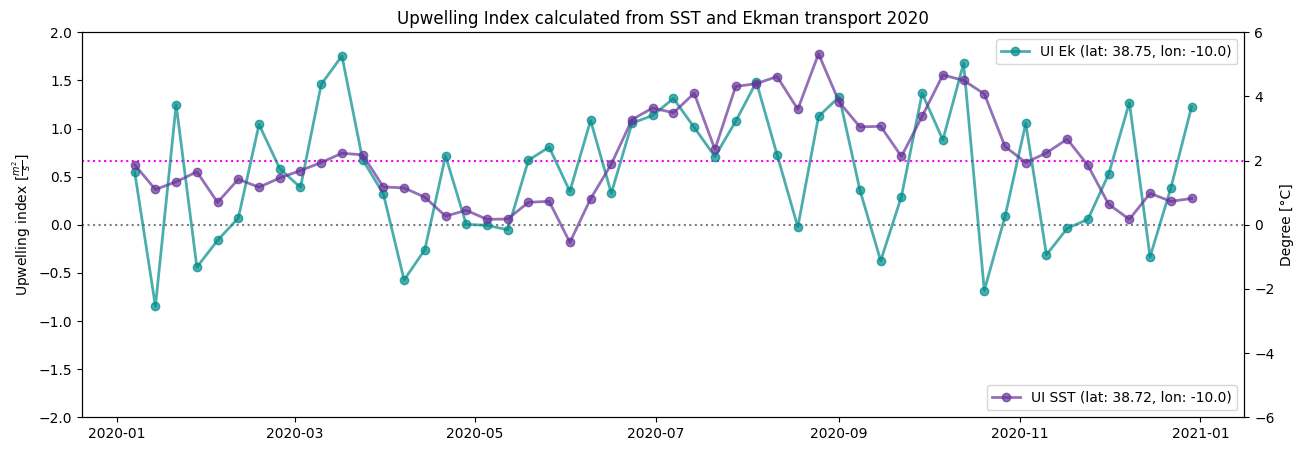

In [6]:
# compare only 1 year of data
fig, ax1 = plt.subplots(figsize=(15,5))

# 0 line
plt.axhline(0, color = 'k', linestyle = ':', alpha = 0.5);
# -2°C line (as signifier for an upwelling event, -2/3 on primary axis = -2 on secondary)
plt.axhline(2/3, color = 'magenta', linestyle = ':')

# primary axis
ax1.plot(UI_Ek.time.sel(time = slice ("2020-01-01", "2020-12-31")), UI_Ek.UI.sel(time = slice ("2020-01-01", "2020-12-31")).sel(lat = 38.7, lon = -10, method = 'nearest'), 
         label = f"UI Ek (lat: {UI_Ek.lat.sel(lat = 38.7, method = 'nearest').values.round(2)}, lon: {UI_Ek.lon.sel(lon = -10, method = 'nearest').values.round(2)})",
         color = 'darkcyan', alpha = 0.7, linewidth = 2, marker = 'o')

# secondary axis 
ax2 = ax1.twinx()
ax2.plot(UI_SST.time.sel(time = slice ("2020-01-01", "2020-12-31")), UI_SST.UI.sel(time = slice ("2020-01-01", "2020-12-31")).sel(lat = 38.7, lon = -10, method = 'nearest'), 
         label = f"UI SST (lat: {UI_SST.lat.sel(lat = 38.7, method = 'nearest').values.round(2)}, lon: {UI_SST.lon.sel(lon = -10, method = 'nearest').values.round(2)})",
         color = 'rebeccapurple', alpha = 0.7, linewidth = 2, marker = 'o')

# layout 
ax1.set_ylabel(r'Upwelling index [$\frac{m^{2}}{s}$]');
ax1.set_ylim(-2, 2)
ax1.legend(loc = 0)

ax2.set_ylabel('Degree [°C]')
ax2.set_ylim(-6,6)
ax2.legend(loc = 4)

plt.title('Upwelling Index calculated from SST and Ekman transport 2020')
plt.xlabel('Time [yr-m]')


## Plot Overview Lat over Time

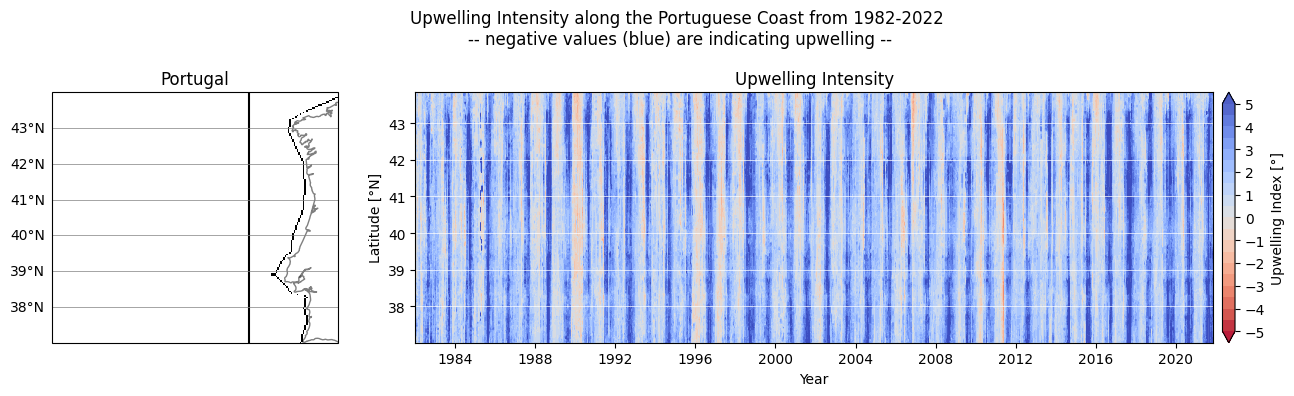

In [7]:
# plot UI SST as a function of time

# set up figure
fig = plt.figure(figsize = (14,4))
gs = fig.add_gridspec(1,2,width_ratios=[1,3])
ax1 = fig.add_subplot(gs[0], projection = ccrs.PlateCarree())
ax2 = fig.add_subplot(gs[1])

# Portugal map
ax1.set_extent([-16, -8, 44, 37])
ax1.coastlines(color = 'black', alpha = 0.5)
gls = ax1.gridlines(draw_labels=False, linewidth = 0.5, color = 'grey')
gls.xlines = False
gls.left_labels = True

# add mid-shelf and 15°W line
UI_SST.Tmid.isel(time = 0).transpose().plot(ax = ax1, cmap = 'Greys_r', levels = np.arange(285, 1000, 1), extend = 'both', 
                                            add_colorbar=False, transform = ccrs.PlateCarree())

lon1, lat1 = ccrs.PlateCarree().transform_point(-10.5 , 37, ccrs.Geodetic())
lon2, lat2 = ccrs.PlateCarree().transform_point(-10.5, 44, ccrs.Geodetic())
ax1.plot([lon1, lon2], [lat1, lat2], transform = ccrs.PlateCarree(), color='black', linewidth=1.5)

ax1.set_title('Portugal')

# plot UI SST
#cols = matplotlib.colors.LinearSegmentedColormap.from_list('',['darkcyan','deeppink']) # attempt at creating own colorbar
im2 = ax2.contourf(UI_SST.UI.time.values, UI_SST.lat.values, UI_SST.UI.sel(lon = - 10, method = 'nearest').transpose(), 
             cmap = 'coolwarm_r', levels = np.arange(-5, 5.5, 0.5), extend = 'both', alpha = 0.9)
ax2.set_ylabel('Latitude [°N]')
ax2.set_xlabel('Year');
ax2.set_title('Upwelling Intensity')
ax2.grid(color = 'white', linewidth = 0.5, axis = 'y')
plt.colorbar(im2, pad = 0.01, label = f'Upwelling Index [°]', ticks = np.arange(-5, 6, 1));

fig.suptitle('Upwelling Intensity along the Portuguese Coast from 1982-2022 \n-- negative values (blue) are indicating upwelling --')
fig.tight_layout()
# fig.savefig('../Iberian_Coast_Upwelling/Figures/Overview_UI_SST.png', dpi = 300)

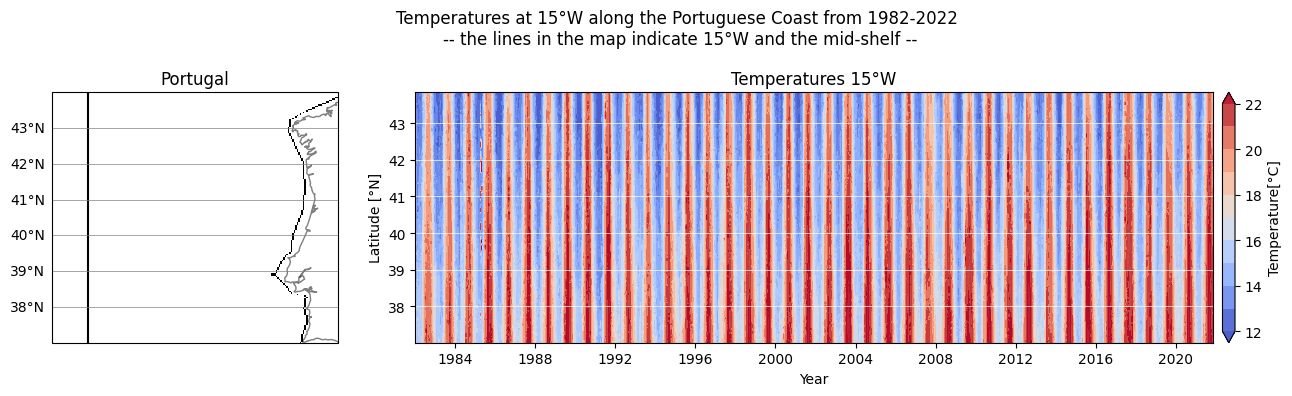

In [41]:
# plot SST Toff15 as a function of time

# set up figure
fig = plt.figure(figsize = (14,4))
gs = fig.add_gridspec(1,2,width_ratios=[1,3])
ax1 = fig.add_subplot(gs[0], projection = ccrs.PlateCarree())
ax2 = fig.add_subplot(gs[1])

# Portugal map
ax1.set_extent([-16, -8, 44, 37])
ax1.coastlines(color = 'black', alpha = 0.5)
gls = ax1.gridlines(draw_labels=False, linewidth = 0.5, color = 'grey')
gls.xlines = False
gls.left_labels = True

# add mid-shelf and 15°W line
UI_SST.Tmid.isel(time = 0).transpose().plot(ax = ax1, cmap = 'Greys_r', levels = np.arange(285, 1000, 1), extend = 'both', 
                                            add_colorbar=False, transform = ccrs.PlateCarree())

lon1, lat1 = ccrs.PlateCarree().transform_point(-15 , 37, ccrs.Geodetic())
lon2, lat2 = ccrs.PlateCarree().transform_point(-15, 44, ccrs.Geodetic())
ax1.plot([lon1, lon2], [lat1, lat2], transform = ccrs.PlateCarree(), color='black', linewidth=1.5)

ax1.set_title('Portugal')

# plot temperatures
im2 = ax2.contourf(UI_SST.UI.time.values, UI_SST.lat.values, (UI_SST.Toff15W.sel(lon = - 15, method = 'nearest').transpose()), 
             cmap = 'coolwarm', levels = np.arange(12, 23, 1), extend = 'both', alpha = 0.9)
ax2.set_ylabel('Latitude [°N]')
ax2.set_xlabel('Year');
ax2.set_title('Temperatures 15°W')
ax2.grid(color = 'white', linewidth = 0.5, axis = 'y')
plt.colorbar(im2, pad = 0.01, label = 'Temperature[°C]');

fig.suptitle('Temperatures at 15°W along the Portuguese Coast from 1982-2022 \n-- the lines in the map indicate 15°W and the mid-shelf --')
fig.tight_layout()
# fig.savefig('../Iberian_Coast_Upwelling/Figures/Overview_T_15W.png', dpi = 300)

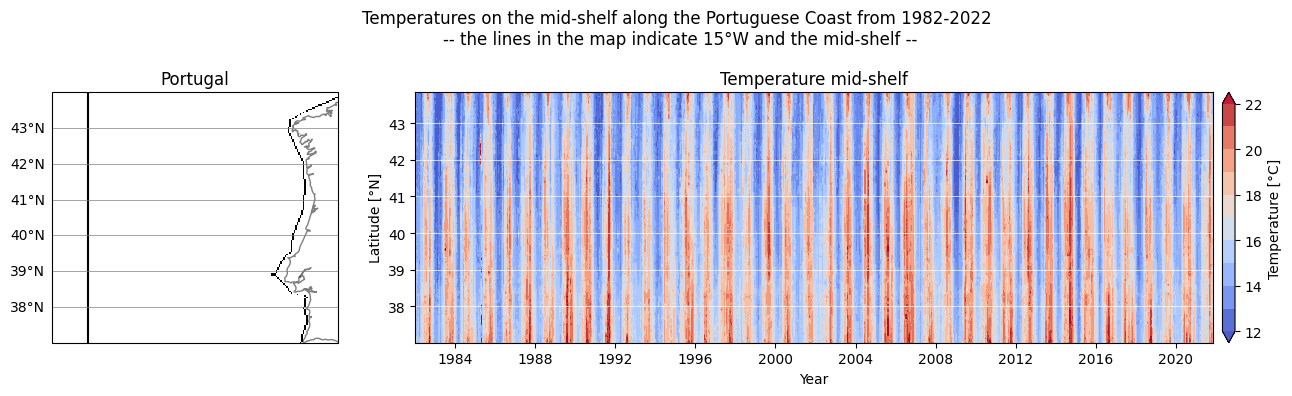

In [42]:
# plot SST Tmid as a function of time

# set up figure
fig = plt.figure(figsize = (14,4))
gs = fig.add_gridspec(1,2,width_ratios=[1,3])
ax1 = fig.add_subplot(gs[0], projection = ccrs.PlateCarree())
ax2 = fig.add_subplot(gs[1])

# Portugal map
ax1.set_extent([-16, -8, 44, 37])
ax1.coastlines(color = 'black', alpha = 0.5)
gls = ax1.gridlines(draw_labels=False, linewidth = 0.5, color = 'grey')
gls.xlines = False
gls.left_labels = True

# add mid-shelf and 15°W line
UI_SST.Tmid.isel(time = 0).transpose().plot(ax = ax1, cmap = 'Greys_r', levels = np.arange(285, 1000, 1), extend = 'both', 
                                            add_colorbar=False, transform = ccrs.PlateCarree())
lon1, lat1 = ccrs.PlateCarree().transform_point(-15 , 37, ccrs.Geodetic())
lon2, lat2 = ccrs.PlateCarree().transform_point(-15, 44, ccrs.Geodetic())
ax1.plot([lon1, lon2], [lat1, lat2], transform = ccrs.PlateCarree(), color='black', linewidth=1.5)

ax1.set_title('Portugal')


# plot temperatures
im2 = ax2.contourf(UI_SST.UI.time.values, UI_SST.lat.values, UI_SST.Tmid.sum(dim = 'lon').transpose(), 
             cmap = 'coolwarm', levels = np.arange(12, 23, 1), extend = 'both', alpha = 0.9)
ax2.set_ylabel('Latitude [°N]')
ax2.set_xlabel('Year');
ax2.set_title('Temperature mid-shelf')
ax2.grid(color = 'white', linewidth = 0.5, axis = 'y')
plt.colorbar(im2, pad = 0.01, label = 'Temperature [°C]');

fig.suptitle('Temperatures on the mid-shelf along the Portuguese Coast from 1982-2022 \n-- the lines in the map indicate 15°W and the mid-shelf --')
fig.tight_layout()
# fig.savefig('../Iberian_Coast_Upwelling/Figures/Overview_T_mid.png', dpi = 300)

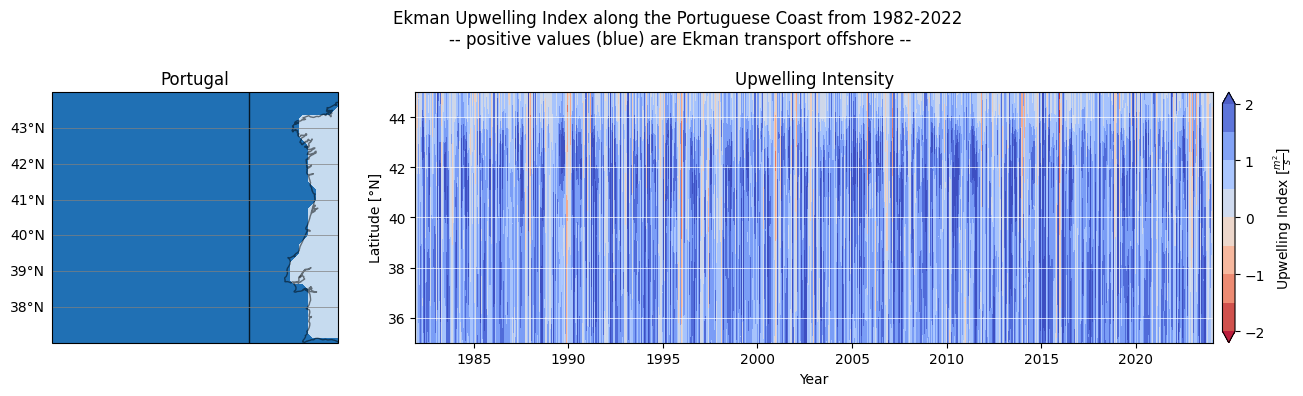

In [6]:
# plot UI Ek as a function of time

# set up figure
fig = plt.figure(figsize = (14,4))
gs = fig.add_gridspec(1,2,width_ratios=[1,3])
ax1 = fig.add_subplot(gs[0], projection = ccrs.PlateCarree())
ax2 = fig.add_subplot(gs[1])

# Portugal map
ax1.set_extent([-16, -8, 44, 37])
ax1.coastlines(color = 'black', alpha = 0.5)
gls = ax1.gridlines(draw_labels=False, linewidth = 0.5, color = 'grey')
gls.xlines = False
gls.left_labels = True

# plot ERA5 land mask
ax1.contourf(UI_Ek.lon, UI_Ek.lat, UI_Ek.lsm, cmap = 'Blues', transform = ccrs.PlateCarree())

# plot 10°W line (line I am plotting my UI Ek for)
lon1, lat1 = ccrs.PlateCarree().transform_point(-10.5 , 37, ccrs.Geodetic())
lon2, lat2 = ccrs.PlateCarree().transform_point(-10.5, 44, ccrs.Geodetic())
ax1.plot([lon1, lon2], [lat1, lat2], transform = ccrs.PlateCarree(), color='black', linewidth=1, alpha = 0.8)

ax1.set_title('Portugal')

# plot UI Ek
im2 = ax2.contourf(UI_Ek.time.values, UI_Ek.lat.values, UI_Ek.UI.sel(lon = - 10, method = 'nearest').transpose(), 
             cmap = 'coolwarm_r', levels = np.arange(-2, 2.5, 0.5), extend = 'both', alpha = 0.9)
ax2.set_ylabel('Latitude [°N]')
ax2.set_xlabel('Year');
ax2.set_title('Upwelling Intensity')
ax2.grid(color = 'white', linewidth = 0.5, axis = 'y')
plt.colorbar(im2, pad = 0.01, label = r'Upwelling Index [$\frac{m^2}{s}$]', ticks = np.arange(-2, 3, 1));

fig.suptitle('Ekman Upwelling Index along the Portuguese Coast from 1982-2022 \n-- positive values (blue) are Ekman transport offshore --')
fig.tight_layout()
# fig.savefig('../Iberian_Coast_Upwelling/Figures/Overview_UI_Ekman.png', dpi = 300)

## Trends 
- this is old now and the stats a bit off the Analyse_UI.ipynb has more up to dat figures
- the temperature comparison T 15°W and T mid-shelf might still be relevant

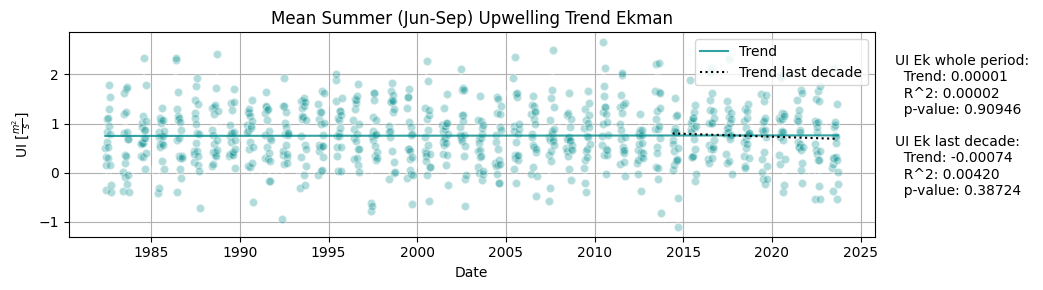

In [44]:
# get values for the trend line analysis
fig = plt.figure(figsize = (9, 3))

x_dates = UI_Ek_summer.time
y = UI_Ek_summer.UI_mean

# calculate a fit line
x_num = dates.date2num(x_dates)
trend = np.polyfit(x_num, y, 1)
fit = np.poly1d(trend)

# calculate fitline only for past decade
# define last decades in years
last_10 = x_dates.dt.isocalendar().year.max().values - 9 # minus nine years because the last year is already fully included 01/2021 - 12/2021

# select last 10 years of data
x_num_10 = np.delete(x_num, (np.where(x_dates.dt.isocalendar().year < last_10))) #x_num[-180:-1]
y_10 = np.delete(y, (np.where(x_dates.dt.isocalendar().year < last_10))) #x_num[-180:-1]

trend_10 = np.polyfit(x_num_10, y_10, 1)
fit_10 = np.poly1d(trend_10)

# general plot again
plt.plot(x_dates, y, marker = 'o', markerfacecolor = 'darkcyan', alpha = 0.3, color = 'white')
plt.xlabel('Date')
plt.ylabel(r'UI [$\frac{m^2}{s}$]')

# get the input numbers for the fit line and convert the numbers back to dates
x_fit = np.linspace(x_num.min(), x_num.max())
plt.plot(dates.num2date(x_fit), fit(x_fit), "darkcyan", linestyle = "-" , alpha = 0.8, label = 'Trend') 

# last 10 years
x_fit_10 = np.linspace(x_num_10.min(), x_num_10.max())
plt.plot(dates.num2date(x_fit_10), fit_10(x_fit_10), "k:", alpha = 1, label = 'Trend last decade') 

plt.legend()
plt.grid()
plt.title('Mean Summer (Jun-Sep) Upwelling Trend Ekman')

## UI_Ek whole period SUMMER
time = np.arange(0, len(UI_Ek_summer.time))
values = y.values
time_with_const = sm.add_constant(time)
model_full = sm.OLS(values, time_with_const).fit()   ## OLS -> ordinary least squares

## UI_Ek last decace SUMMER
time = np.arange(0, len(x_num_10))
values = y_10.values
time_with_const = sm.add_constant(time)
model_10 = sm.OLS(values, time_with_const).fit()   ## OLS -> ordinary least squares

plt.figtext(1, 0.28, f'UI Ek whole period: \n  Trend: {model_full.params[1]:.5f} \n  R^2: {model_full.rsquared:.5f} \n  p-value: {model_full.pvalues[1]:.5f} \n\nUI Ek last decade: \n  Trend: {model_10.params[1]:.5f} \n  R^2: {model_10.rsquared:.5f} \n  p-value: {model_10.pvalues[1]:.5f} \n')

fig.tight_layout()
# fig.savefig('../Iberian_Coast_Upwelling/Figures/UI_Trend_Ek.png', dpi = 300, bbox_inches='tight')

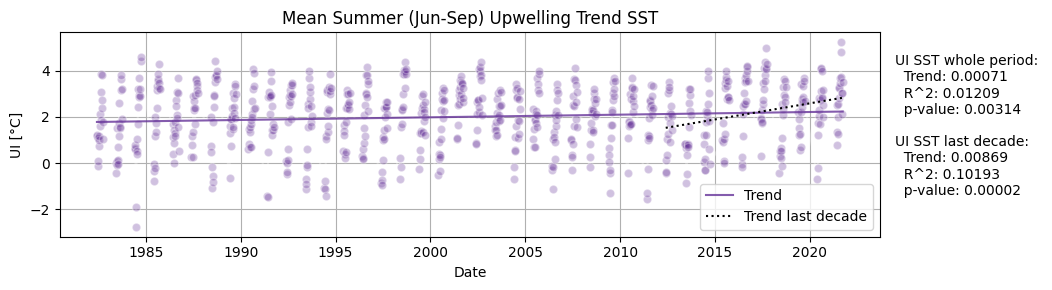

In [45]:
# get values for the trend line analysis
fig = plt.figure(figsize = (9, 3))

x_dates = UI_SST_summer.time
x_num = dates.date2num(x_dates)
x_num_10 = x_num[-180:-1]

y = UI_SST_summer.UI_mean

# calculate a fit line
trend = np.polyfit(x_num, y, 1)
fit = np.poly1d(trend)

# calculate fitline only for past decade
trend_10 = np.polyfit(x_num_10, y[-180:-1], 1)
fit_10 = np.poly1d(trend_10)

# general plot 
plt.plot(x_dates, y, marker = 'o', markerfacecolor = 'rebeccapurple', alpha = 0.3, color = 'white')
plt.xlabel('Date')
plt.ylabel(r'UI [°C]')

# get the input numbers for the fit line and convert the numbers back to dates
x_fit = np.linspace(x_num.min(), x_num.max())
plt.plot(dates.num2date(x_fit), fit(x_fit), color = 'rebeccapurple', linestyle = "-" , alpha = 0.8, label = 'Trend')

# last 10 years
x_fit_10 = np.linspace(x_num_10.min(), x_num_10.max())
plt.plot(dates.num2date(x_fit_10), fit_10(x_fit_10), "k:", alpha = 1, label = 'Trend last decade') 

plt.legend()
plt.grid()
plt.title('Mean Summer (Jun-Sep) Upwelling Trend SST')

## UI_SST whole period
time = np.arange(0, len(UI_SST_summer.time))
values = UI_SST_summer.UI_mean.values
time_with_const = sm.add_constant(time)
model_full = sm.OLS(values, time_with_const).fit()   ## OLS -> ordinary least squares

## UI_SST last decace
time = np.arange(0, len(UI_SST_summer.time.isel(time = slice(-170, None))))
values = UI_SST_summer.UI_mean.isel(time = slice(-170, None)).values
time_with_const = sm.add_constant(time)
model_10 = sm.OLS(values, time_with_const).fit()   ## OLS -> ordinary least squares

plt.figtext(1, 0.28, f'UI SST whole period: \n  Trend: {model_full.params[1]:.5f} \n  R^2: {model_full.rsquared:.5f} \n  p-value: {model_full.pvalues[1]:.5f} \n\nUI SST last decade: \n  Trend: {model_10.params[1]:.5f} \n  R^2: {model_10.rsquared:.5f} \n  p-value: {model_10.pvalues[1]:.5f} \n')

fig.tight_layout()
# fig.savefig('../Iberian_Coast_Upwelling/Figures/UI_Trend_SST.png', dpi = 300, bbox_inches='tight')

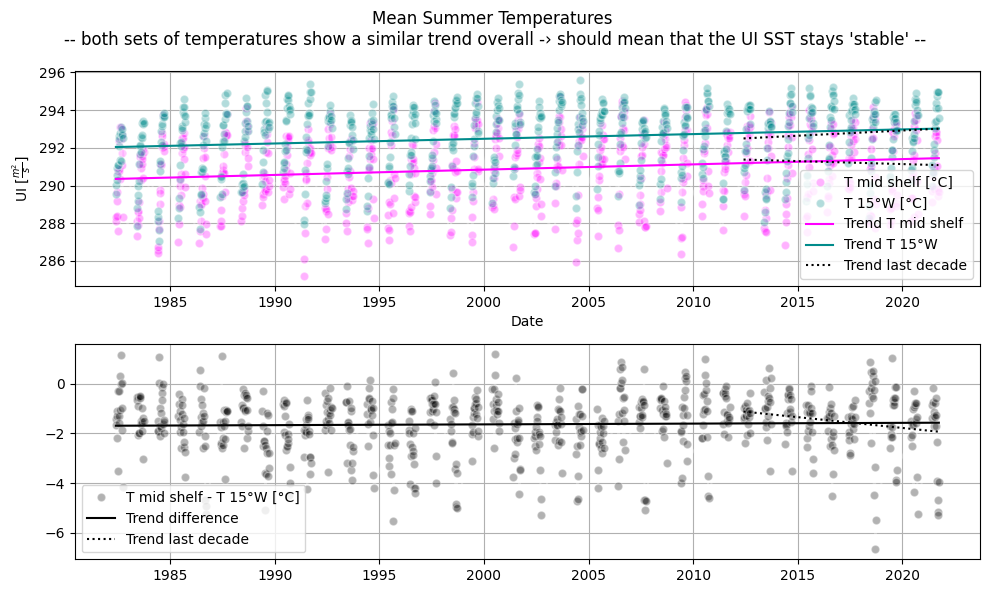

In [13]:
# get values for the trend line analysis
fig, (ax1, ax2) = plt.subplots(2,1, figsize = (10, 6))

x_dates = UI_SST_summer.time
x_num = dates.date2num(x_dates)
x_num_10 = x_num[-180:-1]


y1 = my_functions.calc_meridional_mean(UI_SST_summer, variable = 'Tmid', lon = -8)
y1 = y1.Tmid_mean 
y2 = my_functions.calc_meridional_mean(UI_SST_summer, variable = 'Toff15W', lon = -15)
y2 = y2.Toff15W_mean

# calculate a fit line
trend1 = np.polyfit(x_num, y1, 1)
fit1 = np.poly1d(trend1)

trend2 = np.polyfit(x_num, y2, 1)
fit2 = np.poly1d(trend2)

# calculate fit for last decade
trend1_10 = np.polyfit(x_num_10, y1[-180:-1], 1)
fit1_10 = np.poly1d(trend1_10)

trend2_10 = np.polyfit(x_num_10, y2[-180:-1], 1)
fit2_10 = np.poly1d(trend2_10)

# general plot
ax1.plot(x_dates, y1, marker = 'o', markerfacecolor = 'magenta', alpha = 0.3, color = 'white' , label = 'T mid shelf [°C]')
ax1.plot(x_dates, y2, marker = 'o', markerfacecolor = 'darkcyan', alpha = 0.3, color = 'white', label = 'T 15°W [°C]')
ax1.set_xlabel('Date')
ax1.set_ylabel(r'UI [$\frac{m^2}{s}$]')

# get the input numbers for the fit line and convert the numbers back to dates
x_fit = np.linspace(x_num.min(), x_num.max())
ax1.plot(dates.num2date(x_fit), fit1(x_fit), "magenta", label = 'Trend T mid shelf')
ax1.plot(dates.num2date(x_fit), fit2(x_fit), "darkcyan", label = 'Trend T 15°W')

x_fit = np.linspace(x_num_10.min(), x_num_10.max())
ax1.plot(dates.num2date(x_fit), fit1_10(x_fit), "k:", label = 'Trend last decade')
ax1.plot(dates.num2date(x_fit), fit2_10(x_fit), "k:")

ax1.legend()
ax1.grid()

x_fit = np.linspace(x_num.min(), x_num.max())
ax2.plot(x_dates, y1-y2, marker = 'o', markerfacecolor = 'black', alpha = 0.3, color = 'white' , label = 'T mid shelf - T 15°W [°C]')
ax2.plot(dates.num2date(x_fit), fit1(x_fit) - fit2(x_fit), 'k', label = 'Trend difference')

x_fit = np.linspace(x_num_10.min(), x_num_10.max())
ax2.plot(dates.num2date(x_fit), fit1_10(x_fit) - fit2_10(x_fit), 'k:', label = 'Trend last decade')
ax2.legend()
ax2.grid()

fig.suptitle("Mean Summer Temperatures \n-- both sets of temperatures show a similar trend overall -› should mean that the UI SST stays 'stable' --")
fig.tight_layout()

# fig.savefig('../Iberian_Coast_Upwelling/Figures/Trend_in_SSTs.png', dpi = 300)

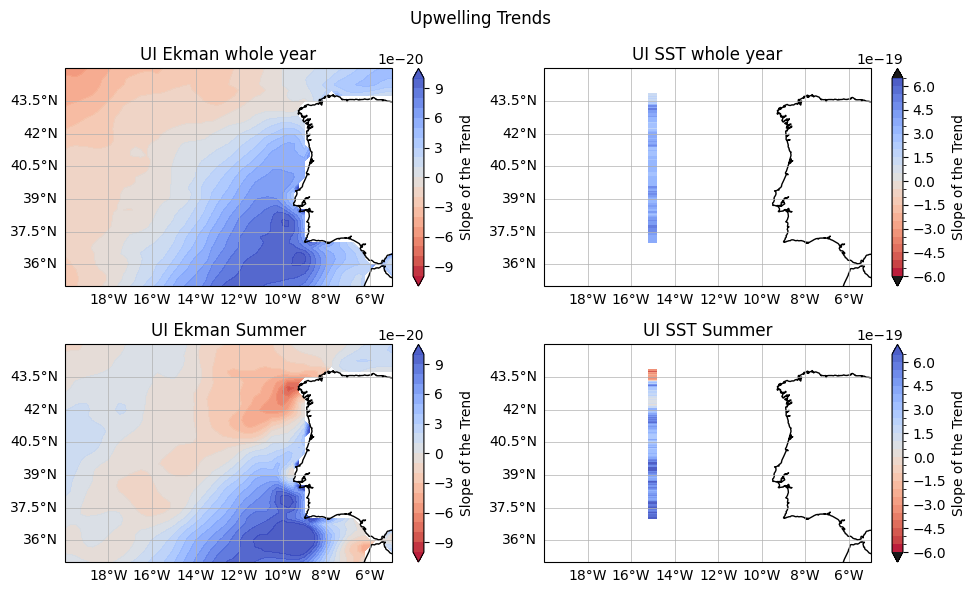

In [14]:
# https://stackoverflow.com/questions/70767908/calculate-linear-trend-in-each-grid-cell
xsize = 2
ysize = 2
fig, axs = plt.subplots(xsize, ysize, figsize = (10, 6), subplot_kw={'projection': ccrs.PlateCarree()})

Vars = [UI_Ek.UI, UI_Ek_summer.UI, UI_SST.UI, UI_SST_summer.UI]
title = ['UI Ekman whole year', 'UI Ekman Summer', 'UI SST whole year', 'UI SST Summer']
i = 0
for x in np.arange(0, xsize):
    for y in np.arange(0, ysize):
        ax = axs[y,x]
        #ax = axs[x]

        # set up cartopy
        ax.set_extent([-20, -5, 45, 35])
        ax.coastlines()
        gls = ax.gridlines(draw_labels=True, linewidth = 0.5)
        gls.top_labels = False 
        gls.right_labels = False

        DS = Vars[i]
        result = DS.polyfit(dim = "time", deg = 1)
        
        if i <= 1:
            
            im = ax.contourf(result.lon, result.lat, result.polyfit_coefficients.sel(degree=1).where(UI_Ek.lsm), 
                         cmap = 'coolwarm_r', levels = np.arange(-1e-19, 1.1e-19, 0.1e-19), extend = 'both', alpha = 0.9)
            plt.colorbar(im, fraction = 0.03, label = 'Slope of the Trend')
            
        if i >1:
            im = result.polyfit_coefficients.sel(lon = slice(-20, -5)).sel(degree=1).plot(ax = ax, x = 'lon',
                         cmap = 'coolwarm_r', levels = np.arange(-6e-19, 7e-19, 0.5e-19), alpha = 0.9, add_colorbar=False)
            plt.colorbar(im, fraction = 0.03, label = 'Slope of the Trend', extend = 'both')
            # add patches to focus on 15°W (otherwise plot shows wider strip from ~18°w to ~8°W)
            ax.add_patch(mpatches.Rectangle(xy=[-18, 36], width = 2.8, height = 8, facecolor = 'white', transform = ccrs.PlateCarree()))
            ax.add_patch(mpatches.Rectangle(xy=[-14.8, 36], width = 8, height = 8, facecolor = 'white', transform = ccrs.PlateCarree()))
    
        ax.set_title(f'{title[i]}')

        i = i+1
    fig.suptitle('Upwelling Trends')
    fig.tight_layout()

# fig.savefig('../Iberian_Coast_Upwelling/Figures/UI_Overview_Slope_of_Trend.png', dpi = 300)

## Trends in upwelling events (count of weeks)
- was not a very useful measure... did not show trends much better than the general trend
- stats are probably off as well

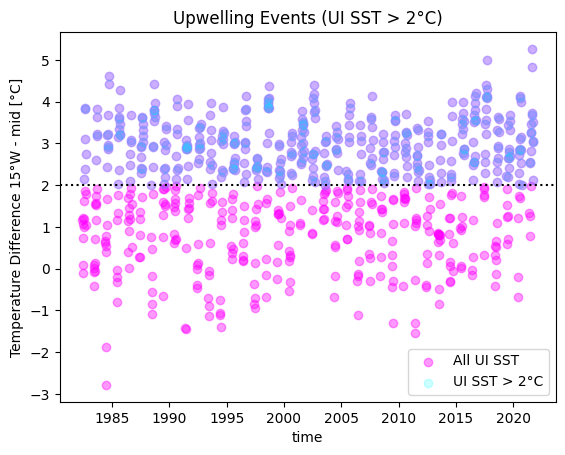

In [15]:
# overview over upwelling events UI SST
UI_SST_summer.UI_mean.plot.scatter(color = 'magenta', alpha = 0.4, label = 'All UI SST')
UI_SST_summer.UI_mean.where(UI_SST_summer.UI_mean > 2).plot.scatter(color = 'cyan', alpha = 0.2, label = 'UI SST > 2°C')
plt.title('Upwelling Events (UI SST > 2°C)')
plt.legend();
plt.ylabel('Temperature Difference 15°W - mid [°C]');
plt.axhline(2, color = 'k', linestyle = ':');

#plt.savefig('../Iberian_Coast_Upwelling/Figures/UI_SST_Events_Scatter.png', dpi = 300)

Text(0.91, 0.28, 'UI SST number of events full period: \n  Trend: 0.07608 \n  R^2: 0.12813 \n  p-value: 0.02334 \n\nUI SST number of events last decade: \n  Trend: 0.69697 \n  R^2: 0.54974 \n  p-value: 0.01412 \n')

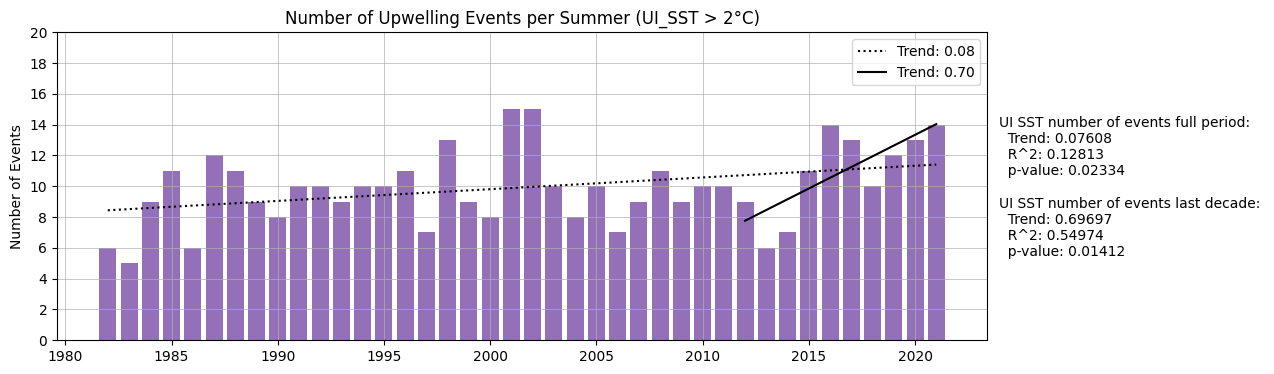

In [16]:
## number of upwelling events UI SST -> defined as UI_SST > 2°
# calculated from UI_SST_summer.UI_mean

fig = plt.figure(figsize = (12,4))

UI_SST_summer_event = UI_SST_summer.UI_mean.where(UI_SST_summer.UI_mean > 2).groupby('time.year').count(dim = 'time')
years = UI_SST_summer_event.year
plt.bar(years, UI_SST_summer_event, color = 'rebeccapurple', alpha = 0.7)
plt.title('Number of Upwelling Events per Summer (UI_SST > 2°C)')
plt.ylabel('Number of Events');

# calculate trend line full period
result = UI_SST_summer_event.polyfit(dim = 'year', deg = 1) 
a = result.polyfit_coefficients.sel(degree=1).values
b = result.polyfit_coefficients.sel(degree=0).values

plt.plot(years, a * years + b, 'k:', label = f'Trend: {a:.2f}');

# calculate trend last decade
result = UI_SST_summer_event[-10:].polyfit(dim = 'year', deg = 1) 
a = result.polyfit_coefficients.sel(degree=1).values
b = result.polyfit_coefficients.sel(degree=0).values

plt.plot(years[-10:], a * years[-10:] + b, 'k', label = f'Trend: {a:.2f}');

plt.legend()
plt.grid(linewidth = 0.5)
plt.yticks(np.arange(0,22,2));

# stats
## UI_SST number of events whole period
time = np.arange(0, len(UI_SST_summer_event.year))
values = UI_SST_summer_event.values
time_with_const = sm.add_constant(time)
model_full = sm.OLS(values, time_with_const).fit()   ## OLS -> ordinary least squares

## UI_SST number of events last decade
time = np.arange(0, len(UI_SST_summer_event.year[-10:]))
values = UI_SST_summer_event[-10:].values
time_with_const = sm.add_constant(time)
model_10 = sm.OLS(values, time_with_const).fit()   ## OLS -> ordinary least squares

plt.figtext(0.91, 0.28, f'UI SST number of events full period: \n  Trend: {model_full.params[1]:.5f} \n  R^2: {model_full.rsquared:.5f} \n  p-value: {model_full.pvalues[1]:.5f} \n\nUI SST number of events last decade: \n  Trend: {model_10.params[1]:.5f} \n  R^2: {model_10.rsquared:.5f} \n  p-value: {model_10.pvalues[1]:.5f} \n')

# fig.savefig('../Iberian_Coast_Upwelling/Figures/UI_SST_Events_Bar.png', dpi = 300, bbox_inches='tight')

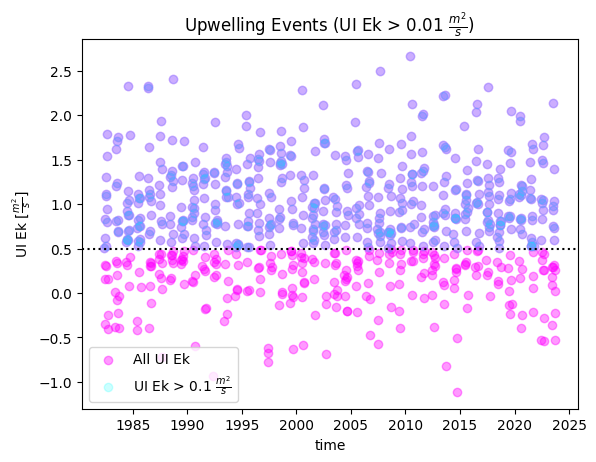

In [17]:
# overview over upwelling events UI Ek
threshold = 0.5
UI_Ek_summer.UI_mean.plot.scatter(color = 'magenta', alpha = 0.4, label = 'All UI Ek')
UI_Ek_summer.UI_mean.where(UI_Ek_summer.UI_mean > threshold).plot.scatter(color = 'cyan', alpha = 0.2, label = r'UI Ek > 0.1 $\frac{m^2}{s}$')
plt.title(r'Upwelling Events (UI Ek > 0.05 $\frac{m^2}{s}$)')
plt.legend();
plt.ylabel(r'UI Ek [$\frac{m^2}{s}$]');
plt.axhline(threshold, color = 'k', linestyle = ':');

# plt.savefig('../Iberian_Coast_Upwelling/Figures/UI_Ek_Events_Scatter.png', dpi = 300)

Text(0.91, 0.28, 'UI Ek number of events full period: \n  Trend: 0.00235 \n  R^2: 0.00025 \n  p-value: 0.92160 \n\nUI Ek number of events last decade: \n  Trend: -0.20000 \n  R^2: 0.08483 \n  p-value: 0.41422 \n')

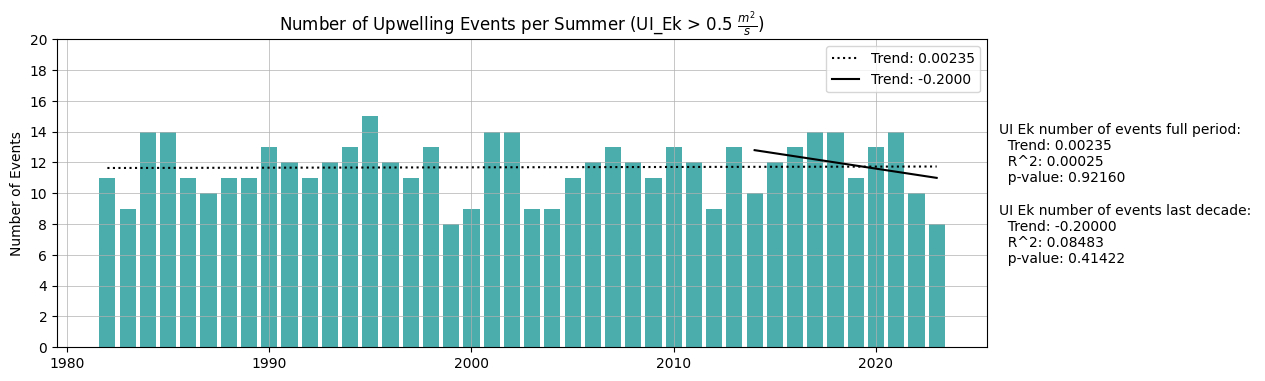

In [18]:
## number of upwelling events UI Ek -> defined as UI_Ek > 0.1 m2/s
# calculated from UI_Ek_summer.UI_mean

fig = plt.figure(figsize = (12,4))

threshold = 0.5

UI_Ek_summer_event = UI_Ek_summer.UI_mean.where(UI_Ek_summer.UI_mean > threshold).groupby('time.year').count(dim = 'time')
years = UI_Ek_summer_event.year
plt.bar(years, UI_Ek_summer_event, color = 'darkcyan', alpha = 0.7)
plt.title(f'Number of Upwelling Events per Summer (UI_Ek > {threshold}' r' $\frac{m^2}{s}$)')
plt.ylabel('Number of Events');

# calculate trend whole period
result = UI_Ek_summer_event.polyfit(dim = 'year', deg = 1) 
a = result.polyfit_coefficients.sel(degree=1).values
b = result.polyfit_coefficients.sel(degree=0).values

plt.plot(years, a * years + b, 'k:', label = f'Trend: {a:.5f}');

# calculate trend last decade
result = UI_Ek_summer_event[-10:].polyfit(dim = 'year', deg = 1) 
a = result.polyfit_coefficients.sel(degree=1).values
b = result.polyfit_coefficients.sel(degree=0).values

plt.plot(years[-10:], a * years[-10:] + b, 'k', label = f'Trend: {a:.4f}');

plt.legend()
plt.grid(linewidth = 0.5)
plt.yticks(np.arange(0,22,2));

## Stats
## UI_Ek number of events whole period
time = np.arange(0, len(UI_Ek_summer_event.year))
values = UI_Ek_summer_event.values
time_with_const = sm.add_constant(time)
model_full = sm.OLS(values, time_with_const).fit()   ## OLS -> ordinary least squares

## UI_Ek number of events last decade
time = np.arange(0, len(UI_Ek_summer_event.year[-10:]))
values = UI_Ek_summer_event[-10:].values
time_with_const = sm.add_constant(time)
model_10 = sm.OLS(values, time_with_const).fit()   ## OLS -> ordinary least squares

plt.figtext(0.91, 0.28, f'UI Ek number of events full period: \n  Trend: {model_full.params[1]:.5f} \n  R^2: {model_full.rsquared:.5f} \n  p-value: {model_full.pvalues[1]:.5f} \n\nUI Ek number of events last decade: \n  Trend: {model_10.params[1]:.5f} \n  R^2: {model_10.rsquared:.5f} \n  p-value: {model_10.pvalues[1]:.5f} \n')

# fig.savefig('../Iberian_Coast_Upwelling/Figures/UI_Ek_Events_Bar.png', dpi = 300, bbox_inches='tight')

### Split UI Ek in half at 40.5°N

In [19]:
# calculate meridional mean (1D Portuguese upwelling index), does meridional mean of UI by default
UI_Ek_N = my_functions.calc_meridional_mean(UI_Ek.where(UI_Ek.lat >= 40.5, drop = True))
UI_Ek_S = my_functions.calc_meridional_mean(UI_Ek.where(UI_Ek.lat <= 40.5, drop = True))

# create subset of summer months, June-September (week 22-39), subsets week 22-39 by default
UI_Ek_N_summer = my_functions.subset_summer(UI_Ek_N)
UI_Ek_S_summer = my_functions.subset_summer(UI_Ek_S)


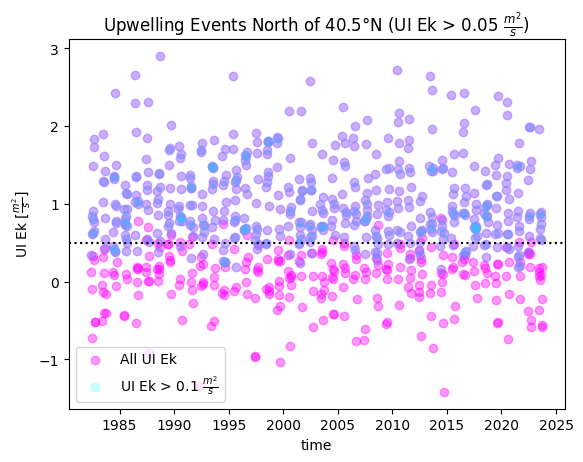

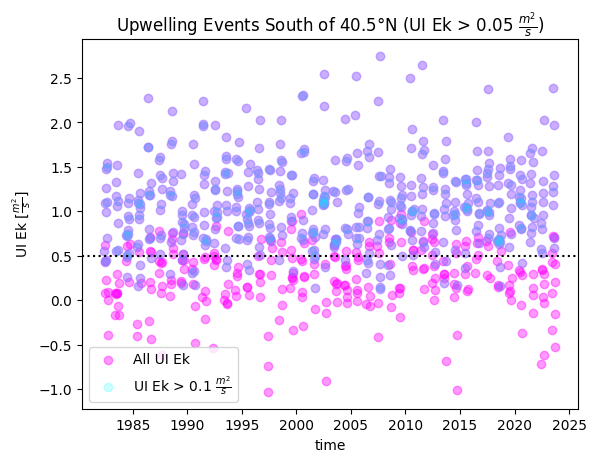

In [20]:
# overview over upwelling events UI Ek
i = 0
name = ['North', 'South']

for ds in [UI_Ek_N_summer, UI_Ek_S_summer]:

    fig = plt.figure()
    
    threshold = 0.5
    ds.UI_mean.plot.scatter(color = 'magenta', alpha = 0.4, label = 'All UI Ek')
    ds.UI_mean.where(UI_Ek_summer.UI_mean > threshold).plot.scatter(color = 'cyan', alpha = 0.2, label = r'UI Ek > 0.1 $\frac{m^2}{s}$')
    plt.title(f'Upwelling Events {name[i]} of 40.5°N' r' (UI Ek > 0.05 $\frac{m^2}{s}$)')
    plt.legend();
    plt.ylabel(r'UI Ek [$\frac{m^2}{s}$]');
    plt.axhline(threshold, color = 'k', linestyle = ':');
    
    # plt.savefig(f'../Iberian_Coast_Upwelling/Figures/UI_Ek_Events_Scatter_{name[i]}.png', dpi = 300)
    i = i + 1

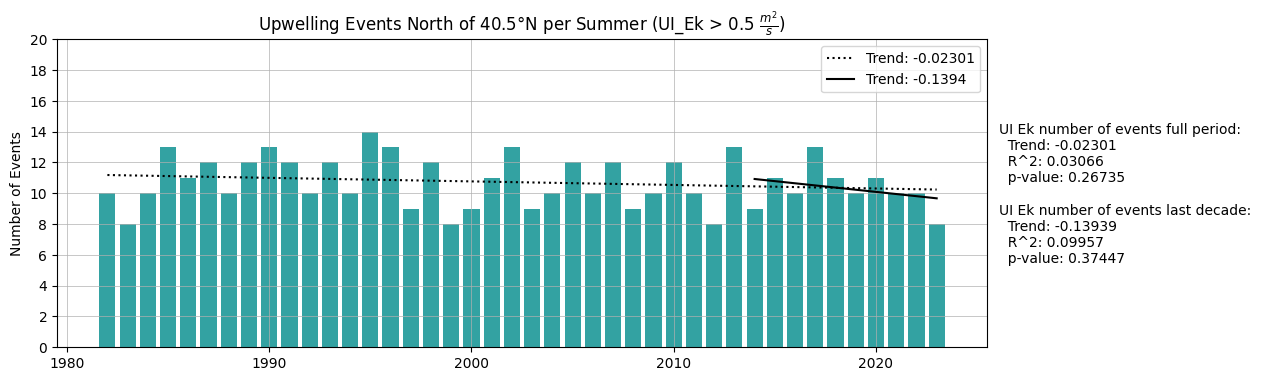

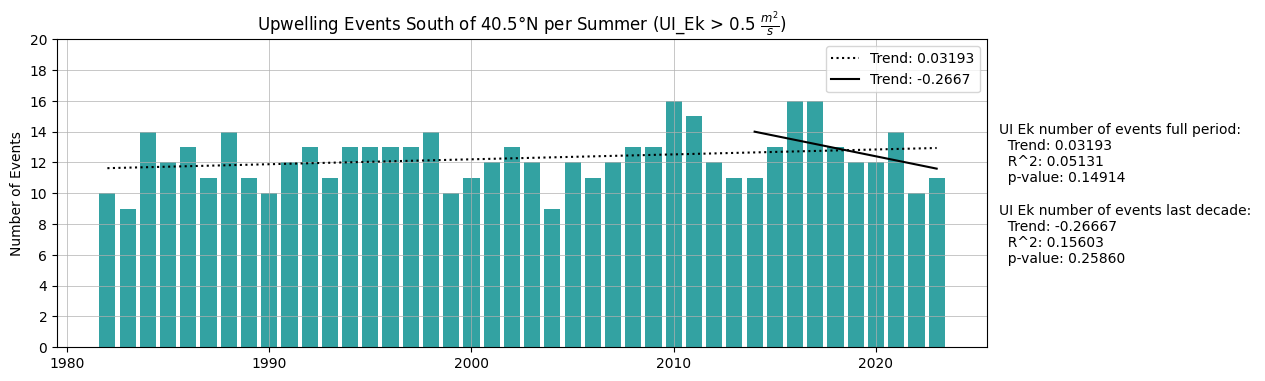

In [21]:
# Split at 40.5°N -> seems to make a difference if we look at the Summer trends above
## number of upwelling events UI Ek -> defined as UI_Ek > 0.1 m2/s
# calculated from UI_Ek_summer.UI_mean

i = 0
name = ['North', 'South']

for ds in [UI_Ek_N_summer, UI_Ek_S_summer]:
    
    fig = plt.figure(figsize = (12,4))
    
    threshold = 0.5
    
    UI_Ek_summer_event = ds.UI_mean.where(ds.UI_mean > threshold).groupby('time.year').count(dim = 'time')
    years = UI_Ek_summer_event.year
    plt.bar(years, UI_Ek_summer_event, color = 'darkcyan', alpha = 0.8)
    plt.title(f'Upwelling Events {name[i]} of 40.5°N per Summer (UI_Ek > {threshold}' r' $\frac{m^2}{s}$)')
    plt.ylabel('Number of Events');
    
    # calculate trend whole period
    result = UI_Ek_summer_event.polyfit(dim = 'year', deg = 1) 
    a = result.polyfit_coefficients.sel(degree=1).values
    b = result.polyfit_coefficients.sel(degree=0).values
    
    plt.plot(years, a * years + b, 'k:', label = f'Trend: {a:.5f}');
    
    # calculate trend last decade
    result = UI_Ek_summer_event[-10:].polyfit(dim = 'year', deg = 1) 
    a = result.polyfit_coefficients.sel(degree=1).values
    b = result.polyfit_coefficients.sel(degree=0).values
    
    plt.plot(years[-10:], a * years[-10:] + b, 'k', label = f'Trend: {a:.4f}');
    
    plt.legend()
    plt.grid(linewidth = 0.5)
    plt.yticks(np.arange(0,22,2));
    
    ## Stats
    ## UI_Ek number of events whole period
    time = np.arange(0, len(UI_Ek_summer_event.year))
    values = UI_Ek_summer_event.values
    time_with_const = sm.add_constant(time)
    model_full = sm.OLS(values, time_with_const).fit()   ## OLS -> ordinary least squares
    
    ## UI_Ek number of events last decade
    time = np.arange(0, len(UI_Ek_summer_event.year[-10:]))
    values = UI_Ek_summer_event[-10:].values
    time_with_const = sm.add_constant(time)
    model_10 = sm.OLS(values, time_with_const).fit()   ## OLS -> ordinary least squares
    
    plt.figtext(0.91, 0.28, f'UI Ek number of events full period: \n  Trend: {model_full.params[1]:.5f} \n  R^2: {model_full.rsquared:.5f} \n  p-value: {model_full.pvalues[1]:.5f} \n\nUI Ek number of events last decade: \n  Trend: {model_10.params[1]:.5f} \n  R^2: {model_10.rsquared:.5f} \n  p-value: {model_10.pvalues[1]:.5f} \n')
    
    # fig.savefig(f'../Iberian_Coast_Upwelling/Figures/UI_Ek_Events_Bar_{name[i]}.png', dpi = 300, bbox_inches='tight')
    i = i + 1

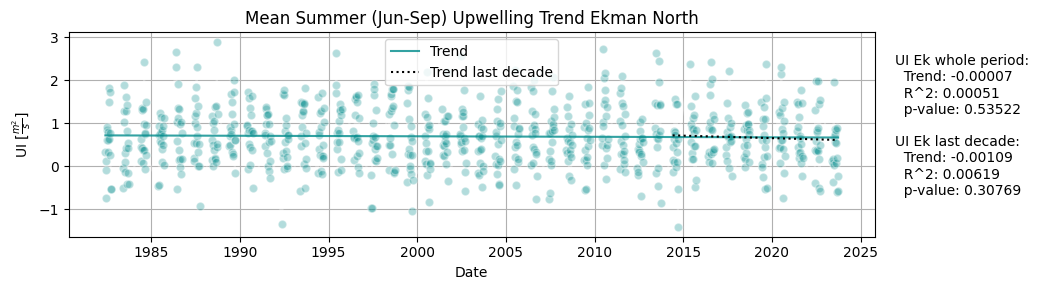

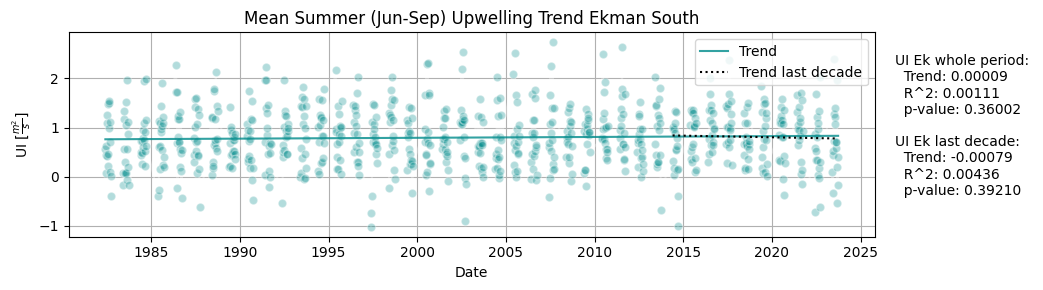

In [22]:
# get values for the trend line analysis
i = 0
name = ['North', 'South']

for ds in [UI_Ek_N_summer, UI_Ek_S_summer]:
    fig = plt.figure(figsize = (9, 3))
    
    x_dates = ds.time
    x_num = dates.date2num(x_dates)
    x_num_10 = x_num[-180:-1]
    
    y = ds.UI_mean
    
    # calculate a fit line
    trend = np.polyfit(x_num, y, 1)
    fit = np.poly1d(trend)
    
    # calculate fitline only for past decade
    trend_10 = np.polyfit(x_num_10, y[-180:-1], 1)
    fit_10 = np.poly1d(trend_10)
    
    # general plot again
    plt.plot(x_dates, y, marker = 'o', markerfacecolor = 'darkcyan', alpha = 0.3, color = 'white')
    plt.xlabel('Date')
    plt.ylabel(r'UI [$\frac{m^2}{s}$]')
    
    # get the input numbers for the fit line and convert the numbers back to dates
    x_fit = np.linspace(x_num.min(), x_num.max())
    plt.plot(dates.num2date(x_fit), fit(x_fit), "darkcyan", linestyle = "-" , alpha = 0.8, label = 'Trend') 
    
    # last 10 years
    x_fit_10 = np.linspace(x_num_10.min(), x_num_10.max())
    plt.plot(dates.num2date(x_fit_10), fit_10(x_fit_10), "k:", alpha = 1, label = 'Trend last decade') 
    
    plt.legend()
    plt.grid()
    plt.title(f'Mean Summer (Jun-Sep) Upwelling Trend Ekman {name[i]}')
    
    ## UI_Ek whole period SUMMER
    time = np.arange(0, len(ds.time))
    values = ds.UI_mean.values
    time_with_const = sm.add_constant(time)
    model_full = sm.OLS(values, time_with_const).fit()   ## OLS -> ordinary least squares
    
    ## UI_Ek last decace SUMMER
    time = np.arange(0, len(ds.time.isel(time = slice(-170, None))))
    values = ds.UI_mean.isel(time = slice(-170, None)).values
    time_with_const = sm.add_constant(time)
    model_10 = sm.OLS(values, time_with_const).fit()   ## OLS -> ordinary least squares
    
    plt.figtext(1, 0.28, f'UI Ek whole period: \n  Trend: {model_full.params[1]:.5f} \n  R^2: {model_full.rsquared:.5f} \n  p-value: {model_full.pvalues[1]:.5f} \n\nUI Ek last decade: \n  Trend: {model_10.params[1]:.5f} \n  R^2: {model_10.rsquared:.5f} \n  p-value: {model_10.pvalues[1]:.5f} \n')
    
    fig.tight_layout()
    # fig.savefig(f'../Iberian_Coast_Upwelling/Figures/UI_Trend_Ek_{name[i]}.png', dpi = 300, bbox_inches='tight')
    i = i + 1

## Significance of Trends
- have changed to calculating the trends with lineregress from scipy.stats
- ...the way this hancdels the time input is weird I think... it does something funny with the trend values

In [23]:
## UI_Ek whole period -> just as a tester that gives me all the info with model.summary()
time = np.arange(0, len(UI_Ek_summer.time))
values = UI_Ek_summer.UI_mean.values

time_with_const = sm.add_constant(time)

model = sm.OLS(values, time_with_const).fit()   ## OLS -> ordinary least squares

print('UI_Ek whole period')
print(model.summary()) # check options dir(model) or even dir(model.parameters)

UI_Ek whole period
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                   0.01294
Date:                Thu, 13 Jun 2024   Prob (F-statistic):              0.909
Time:                        09:49:14   Log-Likelihood:                -686.68
No. Observations:                 756   AIC:                             1377.
Df Residuals:                     754   BIC:                             1387.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7494      0.044 

In [24]:
## UI_Ek whole period but SUMMER
time = np.arange(0, len(UI_Ek_summer.time))
values = UI_Ek_summer.UI_mean.values

time_with_const = sm.add_constant(time)
model = sm.OLS(values, time_with_const).fit()   ## OLS -> ordinary least squares

print('UI_Ek whole period SUMMER')
print(f' Trend: {model.params[1]:.5f} \n R^2: {model.rsquared:.5f} \n p-value: {model.pvalues[1]:.5f} \n')

## UI_Ek last decace
time = np.arange(0, len(UI_Ek_summer.time.isel(time = slice(-170, None))))
values = UI_Ek_summer.UI_mean.isel(time = slice(-170, None)).values

time_with_const = sm.add_constant(time)
model = sm.OLS(values, time_with_const).fit()   ## OLS -> ordinary least squares

print('UI_Ek last decade SUMMER')
print(f' Trend: {model.params[1]:.5f} \n R^2: {model.rsquared:.5f} \n p-value: {model.pvalues[1]:.5f} \n')

## UI_Ek number of events whole period
time = np.arange(0, len(UI_Ek_summer_event.year))
values = UI_Ek_summer_event.values

time_with_const = sm.add_constant(time)
model = sm.OLS(values, time_with_const).fit()   ## OLS -> ordinary least squares

print('UI_Ek number of events last decade SUMMER')
print(f' Trend: {model.params[1]:.5f} \n R^2: {model.rsquared:.5f} \n p-value: {model.pvalues[1]:.5f} \n')

## UI_Ek number of events last decade
time = np.arange(0, len(UI_Ek_summer_event.year[-10:]))
values = UI_Ek_summer_event[-10:].values

time_with_const = sm.add_constant(time)
model = sm.OLS(values, time_with_const).fit()   ## OLS -> ordinary least squares

print('UI_Ek number of events last decade SUMMER')
print(f' Trend: {model.params[1]:.5f} \n R^2: {model.rsquared:.5f} \n p-value: {model.pvalues[1]:.5f} \n')

print('All p-values are > 0.5 i.e. we accept the H0 of no trend. \nThe trends are non-significant.')

UI_Ek whole period SUMMER
 Trend: 0.00001 
 R^2: 0.00002 
 p-value: 0.90946 

UI_Ek last decade SUMMER
 Trend: -0.00096 
 R^2: 0.00612 
 p-value: 0.31042 

UI_Ek number of events last decade SUMMER
 Trend: 0.03193 
 R^2: 0.05131 
 p-value: 0.14914 

UI_Ek number of events last decade SUMMER
 Trend: -0.26667 
 R^2: 0.15603 
 p-value: 0.25860 

All p-values are > 0.5 i.e. we accept the H0 of no trend. 
The trends are non-significant.


In [25]:
## UI_SST whole period
time = np.arange(0, len(UI_SST_summer.time))
values = UI_SST_summer.UI_mean.values

time_with_const = sm.add_constant(time)
model = sm.OLS(values, time_with_const).fit()   ## OLS -> ordinary least squares

print('UI_SST whole period SUMMER')
print(f' Trend: {model.params[1]:.5f} \n R^2: {model.rsquared:.5f} \n p-value: {model.pvalues[1]:.5f} \n')

## UI_SST last decace
time = np.arange(0, len(UI_SST_summer.time.isel(time = slice(-170, None))))
values = UI_SST_summer.UI_mean.isel(time = slice(-170, None)).values

time_with_const = sm.add_constant(time)
model = sm.OLS(values, time_with_const).fit()   ## OLS -> ordinary least squares

print('UI_SST last decade SUMMER')
print(f' Trend: {model.params[1]:.5f} \n R^2: {model.rsquared:.5f} \n p-value: {model.pvalues[1]:.5f} \n')

## UI_SST number of events whole period
time = np.arange(0, len(UI_SST_summer_event.year))
values = UI_SST_summer_event.values

time_with_const = sm.add_constant(time)
model = sm.OLS(values, time_with_const).fit()   ## OLS -> ordinary least squares

print('UI_SST number of events last decade SUMMER')
print(f' Trend: {model.params[1]:.5f} \n R^2: {model.rsquared:.5f} \n p-value: {model.pvalues[1]:.5f} \n')

## UI_SST number of events last decade
time = np.arange(0, len(UI_SST_summer_event.year[-10:]))
values = UI_SST_summer_event[-10:].values

time_with_const = sm.add_constant(time)
model = sm.OLS(values, time_with_const).fit()   ## OLS -> ordinary least squares

print('UI_SST number of events last decade SUMMER')
print(f' Trend: {model.params[1]:.5f} \n R^2: {model.rsquared:.5f} \n p-value: {model.pvalues[1]:.5f} \n')

print('All p-values are < 0.5 i.e. we can reject the H0 of no trend. \nThe trends are significant.')

UI_SST whole period SUMMER
 Trend: 0.00071 
 R^2: 0.01209 
 p-value: 0.00314 

UI_SST last decade SUMMER
 Trend: 0.00869 
 R^2: 0.10193 
 p-value: 0.00002 

UI_SST number of events last decade SUMMER
 Trend: 0.07608 
 R^2: 0.12813 
 p-value: 0.02334 

UI_SST number of events last decade SUMMER
 Trend: 0.69697 
 R^2: 0.54974 
 p-value: 0.01412 

All p-values are < 0.5 i.e. we can reject the H0 of no trend. 
The trends are significant.


## Correlation

In [26]:
corr_summer = np.corrcoef(UI_SST_summer.UI_mean.values, UI_Ek_summer.UI_mean.isel(time = slice(0, 720)).values)
corr_summer

array([[1.        , 0.19015173],
       [0.19015173, 1.        ]])

In [27]:
# test what happens to the correlation coefficient we look at a delayed respones of SST to Ek
corr = np.zeros(53)
for i in np.arange(0,53):
    # first select the time slice where UI Ek and UI SST overlap (time = slice(..., ...)) my UI_Ek starts a little earlier and is a little longer adjust time to match
    # then with every run of the loop add a week delay to the time window in UI SST 
    corr[i] = (np.corrcoef(UI_Ek.UI_mean.isel(time = slice(5, 2032)).values, UI_SST.UI_mean.isel(time = slice(0 + i, -53 + i)).values))[0,1] # subselect the correlation value
    if i < 10:
        print(f'Correlation with {i} week delay: {corr[i]}')

Correlation with 0 week delay: 0.2164603806658977
Correlation with 1 week delay: 0.3100671362490585
Correlation with 2 week delay: 0.29849987946461276
Correlation with 3 week delay: 0.28521476754694847
Correlation with 4 week delay: 0.2756456417802802
Correlation with 5 week delay: 0.280108922274988
Correlation with 6 week delay: 0.27775988460176665
Correlation with 7 week delay: 0.2790702709380345
Correlation with 8 week delay: 0.2838706042006475
Correlation with 9 week delay: 0.2803618069447757


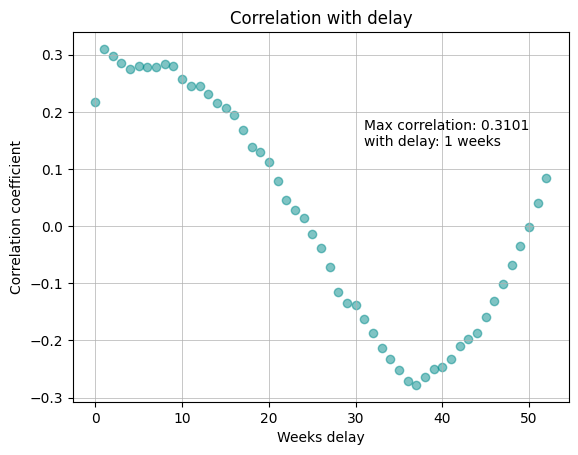

In [28]:
# plot the correlation 
plt.scatter(np.arange(0,53), corr, color = 'darkcyan', alpha = 0.5);
plt.title('Correlation with delay')
plt.text(31, 0.14, f'Max correlation: {corr.max():.4f} \nwith delay: {np.where(corr ==  corr.max())[0][0]} weeks')
plt.xlabel('Weeks delay')
plt.ylabel('Correlation coefficient')
plt.grid(linewidth = 0.5)

In [29]:
# correlation of number of events
corr_summer_events = np.corrcoef(UI_SST_summer_event.values, UI_Ek_summer_event.sel(year = slice(1982, 2021)).values)
corr_summer_events

array([[1.        , 0.54073406],
       [0.54073406, 1.        ]])

In [30]:
# correlation events in summer with 30 day delay (without 'rolling over years')
corr_summer_week_delay = np.zeros([5,41])

for delay in np.arange(0, 5):
    i = 0
    for year in np.unique(UI_SST.time.dt.year.values):
    
        SST = UI_SST.UI_mean.where((UI_SST.week_of_year >= 22 + delay) & (UI_SST.week_of_year <= 39 + delay), drop = True).where(UI_SST.time['time.year'] == year, drop = True)
        Ek = UI_Ek.UI_mean.where((UI_SST.week_of_year >= 22) & (UI_SST.week_of_year <= 39), drop = True).where(UI_SST.time['time.year'] == year, drop = True)
    
        # calculate correlation coefficients
        cor = np.corrcoef(SST, Ek)
        # only save correlation coefficient (instead of whole matrix)
        corr_summer_week_delay[delay, i] = cor[1,0]
    
        i = i + 1

In [31]:
corr_summer_week_delay

array([[ 0.50324631,  0.21550212,  0.18988028,  0.34720978, -0.18053092,
        -0.03843442,  0.27629538,  0.10105107,  0.1322027 ,  0.36968942,
         0.22597792,  0.17878009,  0.22547696,  0.18117885,  0.0090943 ,
         0.46881211,  0.15717848, -0.0820041 , -0.10540709,  0.15663624,
         0.07721047,  0.08347775,  0.37484305, -0.03398669, -0.1195421 ,
         0.67465133,  0.01210257,  0.56601455, -0.02348764, -0.1041866 ,
         0.50673762,  0.23196425,  0.22143467, -0.03505354,  0.27208959,
         0.17471698,  0.29446899,  0.22984842,  0.12935872, -0.06547739,
         0.        ],
       [ 0.66924015,  0.3288233 ,  0.30529609,  0.53125131, -0.12004452,
         0.14917357,  0.33734249, -0.005798  ,  0.22704179,  0.50642731,
         0.30762552,  0.35034527,  0.25420047,  0.18313493,  0.05594986,
         0.62297652,  0.3384312 ,  0.14244278,  0.09391154,  0.10963769,
         0.25478476,  0.24892675,  0.56616521,  0.20609083,  0.04561723,
         0.6185709 , -0.05504

In [32]:
corr_summer_week_delay[delay-1:delay, 0:40].shape

(1, 40)

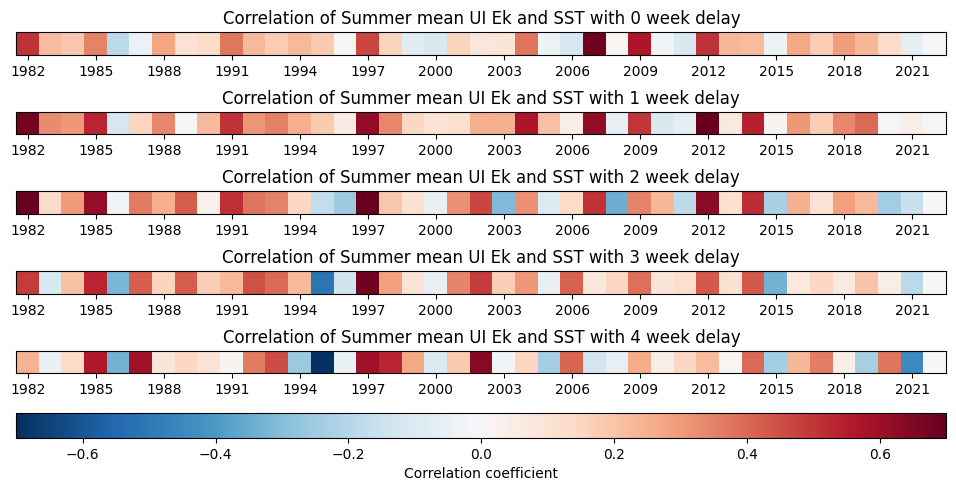

In [33]:
fig, axs = plt.subplots(5, 1, figsize = (12, 5))

for delay in np.arange(0, 5):
    ax = axs[delay]
    
    plot = ax.imshow(corr_summer_week_delay[delay:delay+1, :], cmap = 'RdBu_r', vmin = -0.7, vmax = 0.7)
    ax.set_yticks([])
    ax.set_xticks(ticks = np.arange(0,42,3), labels = np.arange(1982, 2023, 3))
    ax.set_title(f'Correlation of Summer mean UI Ek and SST with {delay} week delay')

# add colorbar
cbar_ax = fig.add_axes([0.125, 0.025, 0.775, 0.05])
fig.colorbar(plot, cax=cbar_ax, label = 'Correlation coefficient', orientation = 'horizontal')

#fig.savefig('../Iberian_Coast_Upwelling/Figures/UI_Summer_Ek_delays_Correlation_mean.png', dpi = 300, bbox_inches='tight')

In [34]:
## same as above but for 3 different latitudes 41, 39 37

corr_summer_1_week_delay_lats = np.zeros([3,40])
lats = [41, 39, 37]

for n in [0, 1, 2]:
    i = 0
    for year in np.unique(UI_SST.time.dt.year.values):
    
        SST = UI_SST.UI.sel(lat = lats[n], lon = -15, method = 'nearest').where((UI_SST.week_of_year >= 22) & (UI_SST.week_of_year <= 39), drop = True).where(UI_SST.time['time.year'] == year, drop = True)
        Ek = UI_Ek.UI.sel(lat = lats[n], lon = -10, method = 'nearest').where((UI_SST.week_of_year >= 21) & (UI_SST.week_of_year <= 38), drop = True).where(UI_SST.time['time.year'] == year, drop = True)
    
        # calculate correlation coefficients
        cor = np.corrcoef(SST, Ek)
        # only save correlation coefficient (instead of whole matrix)
        corr_summer_1_week_delay_lats[n,i] = cor[0,1]
    
        i = i + 1

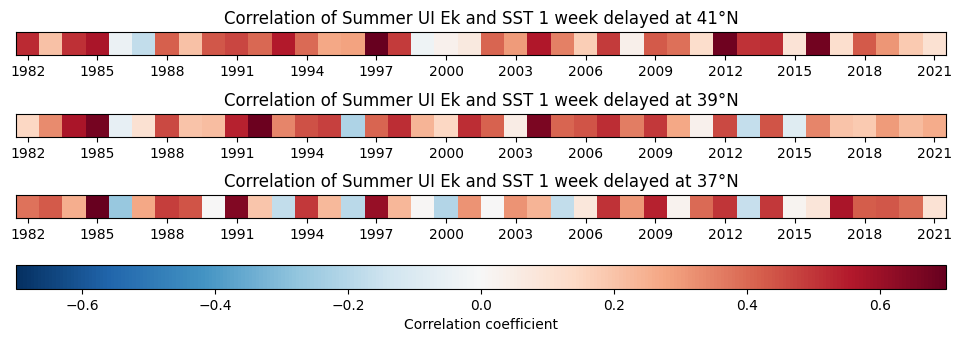

In [35]:
fig, axs = plt.subplots(3, 1, figsize = (12, 3))

for n in np.arange(0, 3):
    ax = axs[n]
    
    plot = ax.imshow(corr_summer_1_week_delay_lats[n:n+1, :], cmap = 'RdBu_r', vmin = -0.7, vmax = 0.7)
    ax.set_yticks([])
    ax.set_xticks(ticks = np.arange(0,42,3), labels = np.arange(1982, 2023, 3))
    ax.set_title(f'Correlation of Summer UI Ek and SST 1 week delayed at {lats[n]}°N')

# add colorbar
cbar_ax = fig.add_axes([0.125, -0.05, 0.775, 0.08])
fig.colorbar(plot, cax=cbar_ax, label = 'Correlation coefficient', orientation = 'horizontal')

#fig.savefig(f'../Iberian_Coast_Upwelling/Figures/UI_Summer_Ek_1_week_delay_Correlation_lats.png', dpi = 300, bbox_inches='tight')

In [36]:
UI_SST

<xarray.Dataset> Size: 272MB
Dimensions:       (lon: 33, time: 2080, lat: 165)
Coordinates:
  * lon           (lon) float64 264B -15.02 -10.0 -9.77 ... -8.228 -8.145 -8.02
  * time          (time) datetime64[ns] 17kB 1982-01-05 ... 2021-11-09
  * lat           (lat) float64 1kB 37.01 37.05 37.1 37.14 ... 43.76 43.8 43.84
Data variables:
    UI            (time, lon, lat) float64 91MB 1.9 2.23 1.8 ... 1.56 1.46 1.58
    Tmid          (time, lon, lat) float64 91MB nan nan nan ... nan nan 288.2
    Toff15W       (time, lon, lat) float64 91MB ...
    UI_mean       (time) float64 17kB 0.5997 0.8697 0.1038 ... 3.152 2.758 2.681
    week_of_year  (time) int64 17kB 1 2 3 4 5 6 7 8 ... 38 39 40 41 42 43 44 45
    month         (time) <U32 266kB 'Jan' 'Jan' 'Jan' ... 'Oct' 'Nov' 'Nov'
Attributes: (12/20)
    Conventions:       CF-1.0
    title:             Data
    source:            CoastNet
    institution:       MARE-UL and Greg
    references:        http://geoportal.coastnet.pt
    easting:           lon
    ...                ...
    CoordinateAxes_:   time lon lat
    CoordSysBuilder_:  ucar.nc2.dataset.conv.CF1Convention
    history:           Data extracted from dataset weekly archive available a...
    time:              2080
    lat:               165
    lon:               31

In [37]:
UI_Ek


<xarray.Dataset> Size: 199MB
Dimensions:       (lat: 41, lon: 61, time: 2201)
Coordinates:
  * lat           (lat) float32 164B 35.0 35.25 35.5 35.75 ... 44.5 44.75 45.0
  * lon           (lon) float32 244B -20.0 -19.75 -19.5 ... -5.5 -5.25 -5.0
  * time          (time) datetime64[ns] 18kB 1981-12-01 ... 2024-01-30
Data variables:
    metss         (time, lat, lon) float32 22MB ...
    mntss         (time, lat, lon) float32 22MB -0.01028 -0.01194 ... 0.009795
    lsm           (lat, lon) bool 3kB True True True True ... True True True
    ek_trans_u    (time, lat, lon) float64 44MB -0.1199 -0.1393 ... 0.09266
    ek_trans_v    (time, lat, lon) float64 44MB -0.8584 -0.8329 ... -0.2697
    wind_stress   (time, lat, lon) float32 22MB 0.07431 0.0724 ... 0.03015
    UI            (time, lat, lon) float64 44MB 0.1199 0.1393 ... -0.09266
    UI_mean       (time) float64 18kB 0.9822 0.2677 0.1392 ... -0.1772 -0.6275
    week_of_year  (time) int64 18kB 49 50 51 52 53 1 2 3 ... 50 51 52 1 2 3 4 5
    month         (time) <U32 282kB 'Dec' 'Dec' 'Dec' ... 'Jan' 'Jan' 'Feb'
    mid_shelf     (lat, lon) bool 3kB False False False ... False False False
Attributes:
    Conventions:  CF-1.7
    institution:  European Centre for Medium-Range Weather Forecasts
    history:      2024-04-16T05:35 GRIB to CDM+CF via cfgrib-0.9.9.1/ecCodes-...
    source:       ECMWF